# Week 7 Exercises


## Ex 1: Convolution and Pooling
In this exercise we will see if we can get a better grasp of convolution and pooling.
Your job is to implement basic convolution and pooling.

For this we need the python package pillow  which you need to install

- The Convolution operator that takes a $d \times d$ weight matrix and a 1 channel image (e.g. gray scale), and applies the convolution between the weight matrix and the image.
- The max pooling operator takes an input image and a max pooling size and returns the pooled output.
    For simplicity we only consider 2 x 2 max pooling with a stride of 2.
- Test your convolution implementation with the $3 \times 3$ matrix with -1 everywhere except in the middle where it is 8. This is a classic edge detector pattern also seen in the lecture.
- Test your pooling implementation by applying a $2 \times 2$ max pooling to the output of the convolution.

We assume that we pad the input to ensure the output of the convolution is the same width and height as the input image.

To compare your implementation we have supplied code that applies the convolution and the pooling operator from the neural net package in pytorch.





image shape (559, 500)


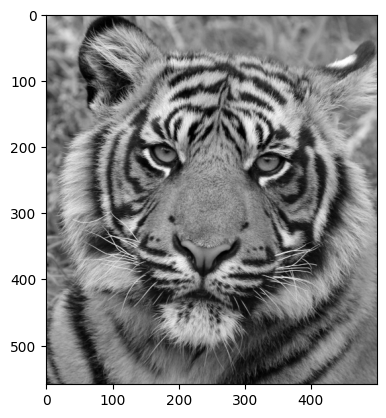

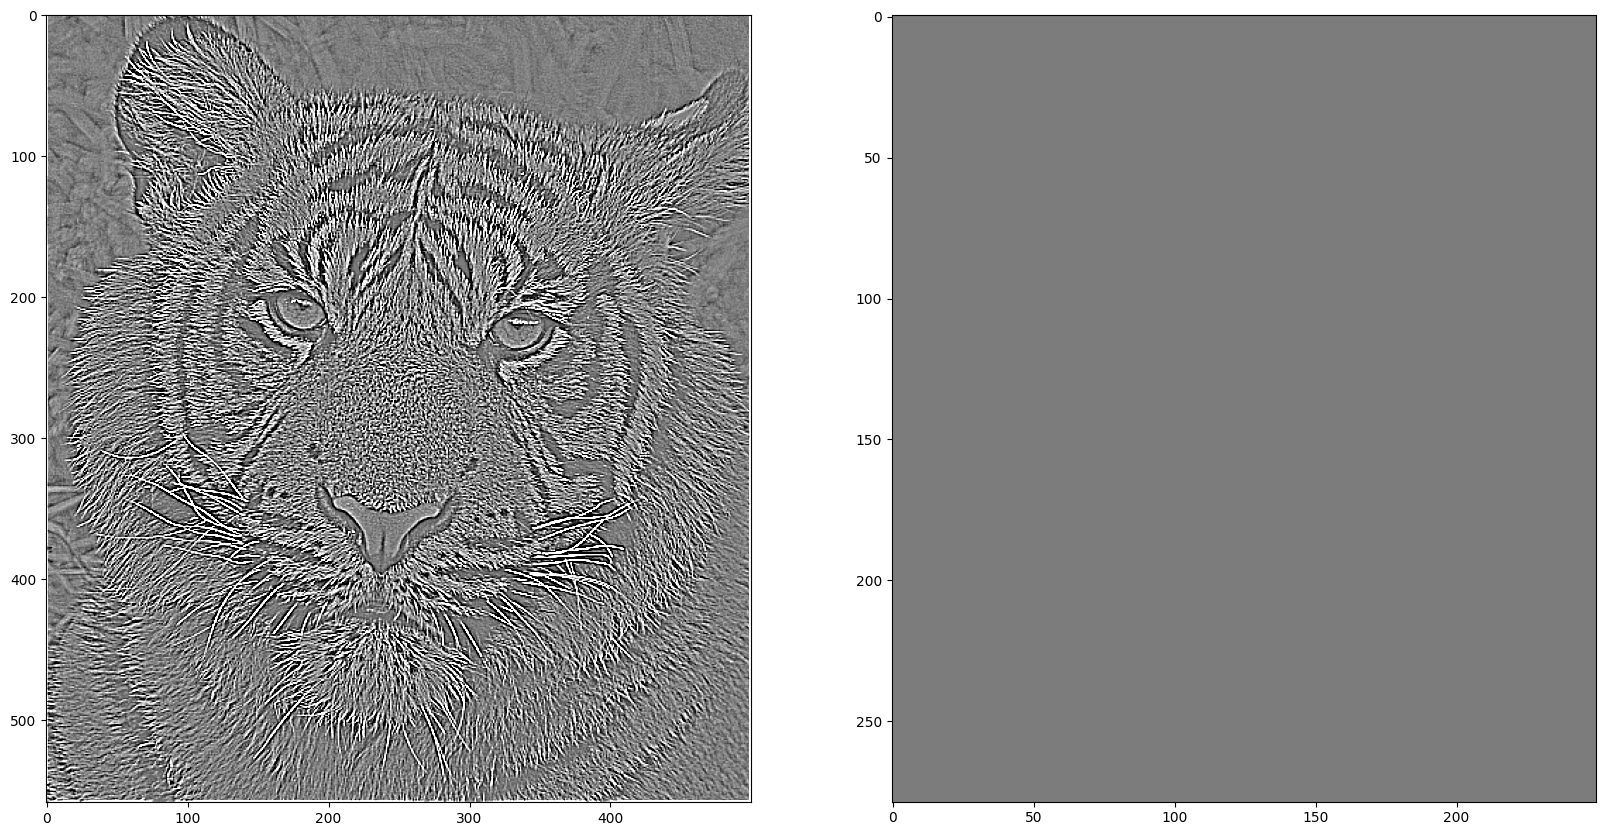

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image #(package name is pillow - i.e. pip3 install pillow )
import os
filename = 'tiger.bmp'

img = Image.open(filename)
tiger = np.array(img)
print('image shape', tiger.shape)
plt.imshow(tiger, cmap='gray')
plt.show()

def conv2d(img, w):
    """ Return the result of applying the convolution defined by w to img - 
    for simplicity assume that w is square"""
    w_dim = w.shape[0]
    pad = w_dim - 2
    padded_img = np.pad(img, [pad, pad], 'constant', constant_values=0)    
    out = np.zeros(img.shape)
    ### YOUR CODE HERE
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j] = np.sum(padded_img[i:i+w_dim, j:j+w_dim] * w)
    ### END CODE
    return out

def max_pool2d(img):
    """ Return the result of applying the 2 x 2 max pooling operator to mig (halve the width and height of image)"""
    out = np.zeros((int(img.shape[0]/2), int(img.shape[1]/2)))
    ### YOUR CODE HERE
    for i in range(0, img.shape[0] - 2, 2):
        for j in range(0, img.shape[1] - 2, 2):
            out[i//2, j//2] = np.max(img[i:i+2, j:j+2])
    ### END CODE
    return out

conv_filter = np.array([[-1., -1., -1.], [-1., 8, -1.], [-1., -1., -1.]])
convoluted_tiger = conv2d(tiger, conv_filter)
pooled_tiger = max_pool2d(convoluted_tiger)
plot_min = convoluted_tiger.mean()-convoluted_tiger.std()
plot_max = convoluted_tiger.mean()+convoluted_tiger.std()
fig, axes = plt.subplots(1, 2, figsize=(20, 16))
axes[0].imshow(convoluted_tiger, cmap='gray', vmin=plot_min, vmax=plot_max)
axes[1].imshow(pooled_tiger, cmap='gray', vmin=plot_min, vmax=plot_max)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch_tiger = torch.from_numpy(tiger).view(1, 1, tiger.shape[0], tiger.shape[1]).double()
print('original',tiger.min(),tiger.max())
print('image shape', torch_tiger.shape)
tv = torch.tensor([[-1., -1., -1.], [-1., 8, -1.], [-1., -1., -1.]])
tv = tv.view(1, 1, 3, 3).double()
torch_convoluted_tiger = F.conv2d(torch_tiger, tv, torch.tensor([0.], dtype=torch.double), 1, 1, 1, 1)
numpy_convoluted_tiger = torch_convoluted_tiger.numpy().squeeze()
print('convoluted_tiger shape', numpy_convoluted_tiger.shape)
print('conv diff norm', np.linalg.norm(numpy_convoluted_tiger - convoluted_tiger))
torch_pooled_tiger = F.max_pool2d(torch_convoluted_tiger, kernel_size=(2, 2))
numpy_pooled_tiger = torch_pooled_tiger.numpy().squeeze()
print('pool diff norm', np.linalg.norm(numpy_pooled_tiger - pooled_tiger))
fig, axes = plt.subplots(1, 2, figsize=(20, 16))
plot_data_min = numpy_convoluted_tiger.mean()-numpy_convoluted_tiger.std()
plot_data_max = numpy_convoluted_tiger.mean()+numpy_convoluted_tiger.std()
axes[0].imshow(numpy_convoluted_tiger, cmap='gray', vmin=plot_data_min, vmax=plot_data_max)
axes[1].imshow(numpy_pooled_tiger, cmap='gray', vmin=plot_data_min, vmax=plot_data_max)
plt.show()

## Ex 2:  Bias Variance 

-   Does the Bias and Variance terms (two numbers) in the Bias Variance
    decomposition depend on the learning algorithm?

-   What is the Variance (in Bias Variance tradoff) if we have a hypothesis
    set of size $1$, namely the constant model $h(x) = 2$? The learning
    algorithm always picks this hypothesis no matter the data.

-   What is the Variance (in the Bias Variance tradeoff) if the simple
    hypothesis from the previous question is replaced by a very
    sophisticated hypothesis? (Like $h(x)=101x^3 + 6x^2-67x+6$).

-   Assume the target function is a second degree polynomial, and the
    input to your algorithm is always eleven distinct (noiseless) points. Your
    hypothesis set is the set of all degree 10 polynomials and the
    learning algorithm returns the hypothesis with the best fit
    (miniming least squared error) given the data. What is the Bias and what
    is the Variance of this learning algorithm?






## Ex 3: Bagging
In this exercise, you must implement bagging for regression. As a base learning algorithm, we use regression trees trained on the bootstrap samples.

Your task is to implement:

    -bootstrap_sample: sample m items with replacement from the training data.

    -fit: train a number of regression trees on bootstrap samples of the training data.

    -predict: return the average prediction among the regression trees trained on bootstrap samples.

    -score: return the mean least squares loss.

Your implementation should result in significantly better test error (around half) when using bagging rather than a single regression tree.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

    
class BaggingRegressor():
    
    def __init__(self, num_trees, sample_fraction):
        self.num_t = num_trees
        self.p = sample_fraction
        self.trees = []
        
    def bootstrap_sample(self, X, y, m):
        """ Returns a new data matrix containing m samples with replacement from (X,y)
    
        Args:
           X: np.array (n, d)  features
           y: np.array (n, ) targets
           m: int, number of bootstrap samples
    
        returns X_boot, y_boot: np.array shape (m,d), np.array (m, ). Bootstrap samples. 
        A data matrix and vector of labels, where each example is a uniform sample from (X,y) 
        with replacement (same element can be sampled multiple times).
        """
        X_boot = None
        y_boot = None
        ### YOUR CODE HERE
        ### END CODE
        return X_boot, y_boot
    
    def fit(self, data, targets):
        """ Use bagging to fit multiple regressions trees to the data
    
        Args:
           data: np.array (n, d)  features
           targets: np.array (n, ) targets
    
        Appends self.num_t regression trees to self.trees, each trained on a bootstrap sample 
        consisting of m = self.p * n examples
        """
        for i in range(self.num_t):
            clf = DecisionTreeRegressor()
            m = (int)(self.p * data.shape[0])
            ### YOUR CODE HERE
            ### END CODE
            self.trees.append(clf)


    def predict(self, X):
        """ Bagging prediction algorithm

        Args
            X: np.array, shape n,d
        
        returns pred: np.array shape n,  model predictions on X. Average of predictions made by 
        regression trees in self.trees
        """
        pred = None
        ### YOUR CODE HERE
        ### END CODE
        return pred
    
    def score(self, X, y):
        """ Compute mean least squares loss of the model

        Args
            X: np.array, shape n,d
            y: np.array, shape n, 

        returns out: scalar - mean least squares loss.
        """
        out = None
        ### YOUR CODE HERE
        ### END CODE
        return out    
    
def main():  
    #load data
    housing = fetch_california_housing()
    # split 80/20 train-test
    X_train, X_test, y_train, y_test = train_test_split(housing.data,
                                                        housing.target,
                                                        test_size=0.2)

    baseline_accuracy = np.mean((y_test-np.mean(y_train))**2)
    print('Least Squares Cost of learning mean of training data:', baseline_accuracy) 
    
    #Regression tree
    clf = DecisionTreeRegressor()
    clf.fit(X_train,y_train)
    predict = clf.predict(X_test)
    regression_tree_accuracy = np.mean((y_test - predict)**2)
    print('Least Squares Cost of RegressionTree:',regression_tree_accuracy)
    
    #Bagging
    bag = BaggingRegressor(20, 0.7)
    bag.fit(X_train,y_train)
    predict = bag.predict(X_test)
    bagging_accuracy = np.mean((y_test - predict)**2)
    print('Least Squares Cost of Bagging:',bagging_accuracy)
    
if __name__ == '__main__':
    main()

## Ex 4: Bias Variance Experiment 
In this exercise you must redo the experiment shown at the lectures.
This exercise takes up quite a lot of space so we have moved it to a separate notebook. Go to [BiasVariance Notebook](BiasVariance.ipynb)

## BONUS Exercise if Time 5: Bias Variance
Book Problem 2.24 part (a)

Short Version:
   
  - The target function is $f(x) = x^2$ and the cost is Least Squares.

  - Sample two points $x_1, x_2$ from $[-1, 1]$ uniformly at random to get the data set $D = \{(x_1, x_1^2), (x_2, x_2^2)\}$

  - Use hypothesis set $\{h(x) = ax +b\mid a,b\in\Bbb R\}$ i.e. lines. There are two parameters $a$ and $b$.

  - Given a data set $D = \{(x_1, x_1^2), (x_2, x_2^2)\}$ the algorithm returns the line that fits these points.

  - Your task is to write down an analytical expression for $\bar{g} = \mathbb{E}_D [h_D]$ where $h_D$ is the hypothesis learned on D.

**Step 1.** What is the in sample error of $h_D$ and why?

**Step 2.** Given $D$ what are $a, b$ (defined by the line between $(x_1, x_1^2)$ and  $(x_2, x_2^2)$)? Hint: $x_2^2- x_1^2 = (x_2-x_1)(x_2 + x_1)$.

**Step 3.** What is the expected value of the slope $a$ over $x_1$ and $x_2$?

**Step 4.** What is the expected value of the intercept $b$ over $x_1$ and $x_2$? 




**More hints**
For the uniform distribution over $[-1,1]$ the mean is $0$ 



